In [1]:
####### dropout resnet18 vs without dropout
#### 
import torch
import sys
sys.path.append("..")
import numpy as np

TAR_PATH = "/home/yifan/dataset/resnet18_init/pairflip/cifar10/0"
REF_PATH = "/home/yifan/dataset/clean/pairflip/cifar10/0"

ENCODER_DIMS=[512,256,256,256,256,2]
DECODER_DIMS= [2,256,256,256,256,512]
VIS_MODEL_NAME = 'vis'

DEVICE='cuda:1'
########## initulize reference data and target data
from AlignVis.DataInit import DataInit
REF_EPOCH = 200
TAR_EPOCH = 200
tar_datainit = DataInit(TAR_PATH,TAR_PATH,TAR_EPOCH,DEVICE)
ref_datainit = DataInit(REF_PATH,REF_PATH,REF_EPOCH,DEVICE)

ref_model, ref_provider, ref_train_data, ref_prediction, ref_prediction_res, ref_scores = ref_datainit.getData()
tar_model, tar_provider, tar_train_data, tar_prediction, tar_prediction_res, tar_scores = tar_datainit.getData()


from AlignVis.ReferenceGenerator import ReferenceGenerator
gen = ReferenceGenerator(ref_provider=ref_provider, tar_provider=tar_provider,REF_EPOCH=REF_EPOCH,TAR_EPOCH=TAR_EPOCH,ref_model=ref_model,tar_model=tar_model,DEVICE=DEVICE)

absolute_alignment_indicates,predict_label_diff_indicates,predict_confidence_Diff_indicates,high_distance_indicates = gen.subsetClassify(18,0.8,0.3,0.05)


from AlignVis_Visualizer.visualizer import visualizer
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

I = np.eye(512)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(TAR_EPOCH),I), projector, 200,[0,1],'tab10')


/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 416.02it/s]


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 7602.73it/s]


absolute alignment indicates number: 194 label diff indicates number: 13 confidence diff indicates number: 10 high distance number: 0


In [19]:
from AlignVis.autoencoder_generator import AutoEncoderGenerator
AutoEncoder_Generator = AutoEncoderGenerator(REF_PATH, REF_PATH, TAR_PATH, TAR_PATH, 200,200, projector, DEVICE)
import os
if os.path.exists(os.path.join(TAR_PATH, "pre_autoencoder——.npy")):
    print("continue")
    autoencoder = AutoEncoder_Generator.encoder_trainer_with_pre_trained(os.path.join(TAR_PATH, "pre_autoencoder——.npy"), os.path.join(TAR_PATH, "pre_autoencoder——.npy"),batch_size=500,num_epochs=5,learning_rate=1e-5,label_flip_rate=0.01)
else:
    print("new one")
    autoencoder = AutoEncoder_Generator.encoder_trainer(os.path.join(TAR_PATH, "pre_autoencoder——.npy"),batch_size=500,num_epochs=1,learning_rate=1e-2)

NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 4053.75it/s]


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 4325.83it/s]


continue
NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 4077.22it/s]


NET resnet18
Finish initialization...


100%|██████████| 3/3 [00:00<00:00, 5249.44it/s]


Epoch [1/5], Loss: 40.8715, Loss decoder: 0.0012,Loss encoder: 0.0022,flip_loss: 131.9049835205078,pred_loss:38.21519088745117,loss_contrastive119.85206549072265,cka_loss0.1353675127029419


100%|██████████| 3/3 [00:00<00:00, 5049.32it/s]


Epoch [2/5], Loss: 42.7778, Loss decoder: 0.0012,Loss encoder: 0.0022,flip_loss: 128.43992614746094,pred_loss:37.421669006347656,loss_contrastive392.9051301269531,cka_loss0.13928616046905518


100%|██████████| 3/3 [00:00<00:00, 9238.56it/s]


KeyboardInterrupt: 

In [2]:
import os
ref_border_path = os.path.join(TAR_PATH,"Model", "Epoch_{:d}".format(TAR_EPOCH),
                                          "aligned_ref_border.npy")
tar_border_path = os.path.join(TAR_PATH,"Model", "Epoch_{:d}".format(TAR_EPOCH),
                                          "aligned_tar_border.npy")
if os.path.exists(ref_border_path) and os.path.exists(tar_border_path):
    print("aaa")
    ref_border_centers_loc = os.path.join(TAR_PATH,"Model", "Epoch_{:d}".format(TAR_EPOCH),
                                          "aligned_ref_border.npy")
    ref_features = np.load(ref_border_centers_loc).squeeze()
    tar_border_centers_loc = os.path.join(TAR_PATH,"Model", "Epoch_{:d}".format(TAR_EPOCH),
                                          "aligned_tar_border.npy")
    tar_features = np.load(tar_border_centers_loc).squeeze()

In [9]:
from AlignVis_eval.AlignEval import Evaluator
eval = Evaluator(projector,ref_provider,tar_provider,REF_EPOCH,TAR_EPOCH)
eval.eval_boundary_nn_ref_in_ref(ref_features)

#train# boundary preserving: 1.29/15 in epoch 200


1.28724

In [2]:

####### generate boundary ponits for tar and ref respectively
from AlignVis.AlignmentBoundaryGenerator import AlignmentBoundaryGenerator
BoundaryGen = AlignmentBoundaryGenerator(REF_PATH,REF_PATH,TAR_PATH,TAR_PATH,REF_EPOCH,TAR_EPOCH,DEVICE)
ref_boundary,tar_boundary = BoundaryGen.get_boundary_point(DEVICE,num_adv_eg=2000)
import torch
###### get border sample features
import torch.nn as nn

ref_feature_model = ref_model.to(DEVICE)
ref_feature_model = nn.Sequential(*list(ref_feature_model.children())[:-1])
with torch.no_grad():
    features = ref_feature_model(ref_boundary)
    ref_features = features.view(ref_boundary.shape[0], -1).cpu().numpy()

###### get border sample features
tar_feature_model = tar_model.to(DEVICE)
tar_feature_model = nn.Sequential(*list(tar_feature_model.children())[:-1])
with torch.no_grad():
    tar_features = tar_feature_model(tar_boundary)
    tar_features = tar_features.view(tar_boundary.shape[0], -1).cpu().numpy()

NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 8607.02it/s]


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:01<00:00, 131.70it/s]


conf1 (4998, 10) (5000, 10) (4998, 10) (5000, 10)
conf1 (4998, 10) (4999, 10) (4998, 10) (4999, 10)
conf1 (4998, 10) (5000, 10) (4998, 10) (5000, 10)
conf1 (5000, 10) (5000, 10) (5000, 10) (5000, 10)
conf1 (5000, 10) (4996, 10) (5000, 10) (4996, 10)
conf1 (4998, 10) (5000, 10) (4998, 10) (5000, 10)
conf1 (4999, 10) (4998, 10) (4999, 10) (4998, 10)
conf1 (4998, 10) (5000, 10) (4998, 10) (5000, 10)
conf1 (4998, 10) (4996, 10) (4998, 10) (4996, 10)
conf1 (4998, 10) (5000, 10) (4998, 10) (5000, 10)
conf1 (5000, 10) (5000, 10) (5000, 10) (5000, 10)
conf1 (4999, 10) (4998, 10) (4999, 10) (4998, 10)
conf1 (4999, 10) (5000, 10) (4999, 10) (5000, 10)
conf1 (5000, 10) (4999, 10) (5000, 10) (4999, 10)
conf1 (4998, 10) (5000, 10) (4998, 10) (5000, 10)
conf1 (4998, 10) (4998, 10) (4998, 10) (4998, 10)
conf1 (4999, 10) (4999, 10) (4999, 10) (4999, 10)
conf1 (4999, 10) (5000, 10) (4999, 10) (5000, 10)
conf1 (4996, 10) (5000, 10) (4996, 10) (5000, 10)
conf1 (4996, 10) (4999, 10) (4996, 10) (4999, 10)


In [21]:
####### add boundary sample to train
import os
autoencoder, ref_features, tar_features = AutoEncoder_Generator.encoder_trainer_with_border(os.path.join(TAR_PATH, "pre_autoencoder——.npy"),os.path.join(TAR_PATH, "pre_autoencoder_withborder.npy"),0.01,500,15,1e-3)

loading boundary
len(input) 52000


100%|██████████| 1/1 [00:00<00:00, 4604.07it/s]


Epoch [1/15], Loss: 2.1723, Loss decoder: 0.0030,Loss encoder: 0.0050,pred_loss:66.82830047607422,cka_loss0.13405030965805054,flip_loss:136.19876098632812


100%|██████████| 1/1 [00:00<00:00, 3253.92it/s]


Epoch [2/15], Loss: 2.1908, Loss decoder: 0.0030,Loss encoder: 0.0052,pred_loss:62.4997444152832,cka_loss0.13969509303569794,flip_loss:141.795654296875


100%|██████████| 1/1 [00:00<00:00, 3390.71it/s]


Epoch [3/15], Loss: 1.9639, Loss decoder: 0.0029,Loss encoder: 0.0051,pred_loss:49.8250846862793,cka_loss0.1254069060087204,flip_loss:133.2272186279297


100%|██████████| 1/1 [00:00<00:00, 3264.05it/s]


Epoch [4/15], Loss: 1.7957, Loss decoder: 0.0027,Loss encoder: 0.0051,pred_loss:40.267208099365234,cka_loss0.10366763174533844,flip_loss:128.155517578125


100%|██████████| 1/1 [00:00<00:00, 4563.99it/s]


Epoch [5/15], Loss: 1.8623, Loss decoder: 0.0028,Loss encoder: 0.0052,pred_loss:39.698219299316406,cka_loss0.1410432755947113,flip_loss:131.6365509033203


100%|██████████| 1/1 [00:00<00:00, 2490.68it/s]


Epoch [6/15], Loss: 1.9266, Loss decoder: 0.0028,Loss encoder: 0.0053,pred_loss:42.23069381713867,cka_loss0.1511947065591812,flip_loss:134.50047302246094


100%|██████████| 1/1 [00:00<00:00, 3953.16it/s]


Epoch [7/15], Loss: 1.8958, Loss decoder: 0.0027,Loss encoder: 0.0055,pred_loss:40.23863983154297,cka_loss0.1348293125629425,flip_loss:135.0318603515625


100%|██████████| 1/1 [00:00<00:00, 5309.25it/s]


Epoch [8/15], Loss: 1.6455, Loss decoder: 0.0025,Loss encoder: 0.0059,pred_loss:26.78697395324707,cka_loss0.11130686104297638,flip_loss:125.79704284667969


100%|██████████| 1/1 [00:00<00:00, 5059.47it/s]


Epoch [9/15], Loss: 1.6923, Loss decoder: 0.0024,Loss encoder: 0.0068,pred_loss:20.90785789489746,cka_loss0.06443004310131073,flip_loss:140.96144104003906


100%|██████████| 1/1 [00:00<00:00, 2931.03it/s]


Epoch [10/15], Loss: 1.3811, Loss decoder: 0.0022,Loss encoder: 0.0066,pred_loss:10.55052661895752,cka_loss0.04089708998799324,flip_loss:122.5850830078125


100%|██████████| 1/1 [00:00<00:00, 4040.76it/s]


Epoch [11/15], Loss: 1.4982, Loss decoder: 0.0023,Loss encoder: 0.0067,pred_loss:14.161876678466797,cka_loss0.05373415723443031,flip_loss:129.38453674316406


100%|██████████| 1/1 [00:00<00:00, 2692.11it/s]


Epoch [12/15], Loss: 1.4515, Loss decoder: 0.0022,Loss encoder: 0.0066,pred_loss:11.274126052856445,cka_loss0.042768172919750214,flip_loss:128.72117614746094


100%|██████████| 1/1 [00:00<00:00, 2676.65it/s]


Epoch [13/15], Loss: 1.5048, Loss decoder: 0.0023,Loss encoder: 0.0067,pred_loss:13.117754936218262,cka_loss0.03758177161216736,flip_loss:132.70883178710938


100%|██████████| 1/1 [00:00<00:00, 5652.70it/s]


Epoch [14/15], Loss: 1.4906, Loss decoder: 0.0022,Loss encoder: 0.0066,pred_loss:10.342294692993164,cka_loss0.031083406880497932,flip_loss:134.7281951904297


100%|██████████| 1/1 [00:00<00:00, 4169.29it/s]

Epoch [15/15], Loss: 1.5741, Loss decoder: 0.0023,Loss encoder: 0.0065,pred_loss:13.843770980834961,cka_loss0.039140548557043076,flip_loss:138.76866149902344


In [22]:
eval.eval_boundary_nn_autoencoder(tar_features, autoencoder)

#train# boundary preserving: 0.69/15 in epoch 200


0.68882

In [26]:
import os
location_R = os.path.join(TAR_PATH, "Model","Epoch_{:d}".format(TAR_EPOCH), "aligned_ref_border.npy")
location_T = os.path.join(TAR_PATH, "Model","Epoch_{:d}".format(TAR_EPOCH), "aligned_tar_border.npy")
np.save(location_R, ref_features)
np.save(location_T, tar_features)

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 7808.70it/s]


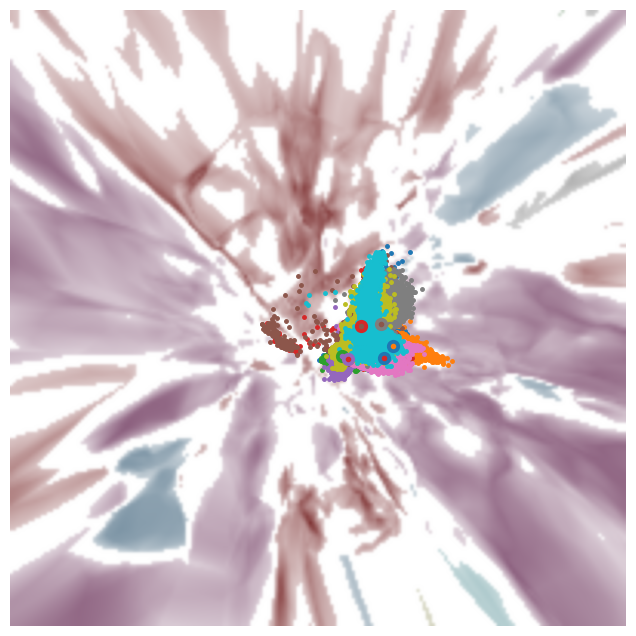

In [23]:
##### visuallize all data
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
VIS_MODEL_NAME = 'vis'
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
Y = torch.Tensor(tar_provider.train_representation(TAR_EPOCH))
encoded_Y = autoencoder.encoder(Y)
I = np.eye(512)
from AlignVis_Visualizer.visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, ref_provider, autoencoder, np.dot(encoded_Y.detach().numpy(), I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(REF_EPOCH, path=os.path.join(TAR_PATH, "vis.png"))

In [6]:
from AlignVis_eval.AlignEval import Evaluator
eval = Evaluator(projector,ref_provider,tar_provider,REF_EPOCH,TAR_EPOCH)
# eval.eval_boundary_nn_autoencoder(tar_border_centers, autoencoder)

In [8]:
eval.eval_nn_train_autoencoder(15,autoencoder)

Fri May 12 11:44:44 2023 Building RP forest with 16 trees
Fri May 12 11:44:44 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Fri May 12 11:45:03 2023 Building RP forest with 16 trees
Fri May 12 11:45:03 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
#train# nn preserving for autoencoder: 1.19/15 in epoch 200


1.18558

In [16]:
eval.eval_ppr_autoencoder(autoencoder)

100%|██████████| 250/250 [00:00<00:00, 4825.45it/s]

#train# autoencoder PPR: 0.77 in epoch 200


0.77062

In [7]:
eval.eval_boundary_nn_ref_in_ref(ref_features,15)

#train# boundary preserving: 1.49/15 in epoch 200


1.49002

In [17]:
eval.eval_boundary_nn_autoencoder(tar_features, autoencoder)

NameError: name 'tar_features' is not defined

In [18]:
from CKA_utils.CKA import CKA, CudaCKA
np_cka = CKA()
encoded_Y = autoencoder.encoder(torch.Tensor(tar_train_data))
encoded_Y = encoded_Y.detach().numpy()
# indicates = np.random.choice(aligned, size=10, replace=False)
indicates = np.random.choice(np.arange(5000), size=1000, replace=False)
print('CKA between absolute alignmnet subset is:',np_cka.kernel_CKA(tar_train_data[indicates],encoded_Y[indicates]))

CKA between absolute alignmnet subset is: 0.9907205807547356


In [19]:
eval.eval_move_direction_preserving(autoencoder,10,1.5)

100%|██████████| 250/250 [00:00<00:00, 3917.60it/s]


long distance move subet number is 20489, short distance move set number is 5


100%|██████████| 250/250 [00:00<00:00, 4136.49it/s]


all reference distance preserving 49409/50000
all target distance preserving 49601/50000
short distance move direction preserving 5/5
long distance move direction preserving 20110/20489


In [23]:
val_same, val_diff = eval.eval_prediction_preserving(autoencoder)

100%|██████████| 250/250 [00:00<00:00, 2563.49it/s]

refere  predction preserving:46512/50000 0.93
target  predction preserving:39261/50000 0.79
ref&tar pred_same preserving:36945/49492 0.75
ref&tar pred_diff preserving:5/508 0.01


In [4]:
import os
location_R = os.path.join(TAR_PATH, "Model","Epoch_{:d}".format(TAR_EPOCH), "aligned_ref_border.npy")
location_T = os.path.join(TAR_PATH, "Model","Epoch_{:d}".format(TAR_EPOCH), "aligned_tar_border.npy")
np.save(location_R, ref_features)
np.save(location_T, tar_features)

In [11]:
ref_border_centers_loc = os.path.join(TAR_PATH,"Model", "Epoch_{:d}".format(TAR_EPOCH),
                                          "aligned_ref_border.npy")
ref_b_features = np.load(ref_border_centers_loc).squeeze()
tar_border_centers_loc = os.path.join(TAR_PATH,"Model", "Epoch_{:d}".format(TAR_EPOCH),
                                          "aligned_tar_border.npy")
tar_b_features = np.load(tar_border_centers_loc).squeeze()

In [13]:
eval.eval_boundary_nn_ref_in_ref(ref_b_features)

#train# boundary preserving: 1.49/15 in epoch 200


1.4875

In [14]:
eval.eval_boundary_nn_autoencoder(tar_b_features,autoencoder,15)

#train# boundary preserving: 1.41/15 in epoch 200


1.40938

In [16]:
def eval_boundary_align_sensitivity(autoencoder, tar_b_features, ref_b_features):
        ############## init ###################
        #init target
        print("123")
        tar_b_pred = tar_provider.get_pred(TAR_EPOCH, tar_b_features)
        tar_b_pred = tar_b_pred + 1e-8
        tar_sort_preds = np.sort(tar_b_pred, axis=1)
        tar_diff = (tar_sort_preds[:, -1] - tar_sort_preds[:, -2]) / (tar_sort_preds[:, -1] - tar_sort_preds[:, 0])
        tar_border = np.zeros(len(tar_diff), dtype=np.uint8) + 0.05
        tar_border[tar_diff < 0.15] = 1

        #init reference
        ref_b_pred = ref_provider.get_pred(REF_EPOCH, ref_b_features)
        ref_b_pred = ref_b_pred + 1e-8
        ref_sort_preds = np.sort(ref_b_pred, axis=1)
        ref_diff = (ref_sort_preds[:, -1] - ref_sort_preds[:, -2]) / (ref_sort_preds[:, -1] - ref_sort_preds[:, 0])
        ref_border = np.zeros(len(ref_diff), dtype=np.uint8) + 0.05
        ref_border[ref_diff < 0.15] = 1
        
        ##### get all boundary list
        all_boundary_list = []
        
        for i in range(len(ref_border)):
            if ref_border[i] == 1 and tar_border[i] == 1:
                all_boundary_list.append(i)
        print(len(all_boundary_list))
        #### get ref low dimensional border
        ref_b_embedding = projector.batch_project(REF_EPOCH, ref_b_features)
        ref_b_inv = projector.batch_inverse(REF_EPOCH,ref_b_embedding)
        ref_b_pred_l = ref_provider.get_pred(REF_EPOCH, ref_b_inv)
        ref_b_pred_l = ref_b_pred_l  + 1e-8
        ref_sort_preds_l  = np.sort(ref_b_pred_l , axis=1)
        ref_diff_l  = (ref_sort_preds_l[:, -1] - ref_sort_preds_l[:, -2]) / (ref_sort_preds_l[:, -1] - ref_sort_preds_l[:, 0])
        ref_border_l = np.zeros(len(ref_diff_l), dtype=np.uint8) + 0.05
        ref_border_l[ref_diff_l < 0.15] = 1
        
        #### get target low dimensional border
        tar_b_embedding = projector.batch_project(REF_EPOCH, autoencoder.encoder(torch.Tensor(ref_b_features)).detach().numpy())
        tar_b_inv = projector.batch_inverse(REF_EPOCH,tar_b_embedding)
        tar_b_inv = autoencoder.decoder(torch.Tensor(tar_b_inv)).detach().numpy()
        tar_b_pred_l = tar_provider.get_pred(REF_EPOCH, tar_b_inv)
        tar_b_pred_l = tar_b_pred_l  + 1e-8
        tar_sort_preds_l  = np.sort(tar_b_pred_l , axis=1)
        tar_diff_l  = (tar_sort_preds_l[:, -1] - tar_sort_preds_l[:, -2]) / (tar_sort_preds_l[:, -1] - tar_sort_preds_l[:, 0])
        tar_border_l = np.zeros(len(tar_diff_l), dtype=np.uint8) + 0.05
        tar_border_l[tar_diff_l < 0.15] = 1

        all_boundary_list_l = []
       
        all_change = []
        all_change_l=[]
      
        for i in range(len(ref_border)):
            ##### low dimension all border
            if ref_border_l[i] == 1 and tar_border_l[i] == 1:
                all_boundary_list_l.append(i)
            if ref_border[i] != tar_border[i]:
                 all_change.append(i)
            if ref_border[i] != tar_border[i] and tar_border_l[i] == tar_border[i]:
                 all_change_l.append(i)
                 
                 
           


        print("boundary sample preserving{}/{}".format(len(all_boundary_list_l),len(all_boundary_list)))
        print("boundary change preserving{}/{}".format(len(all_change_l),len(all_change)))
       
eval_boundary_align_sensitivity(autoencoder,np.concatenate((tar_train_data,tar_features),axis=0), np.concatenate((ref_train_data,ref_features),axis=0))      

123


100%|██████████| 260/260 [00:00<00:00, 8326.80it/s]

2028



100%|██████████| 260/260 [00:00<00:00, 8295.95it/s]

boundary sample preserving2778/2028
boundary change preserving248/520


In [15]:
eval.eval_move_direction_preserving(autoencoder,10,1.5)

100%|██████████| 250/250 [00:00<00:00, 7633.34it/s]


long distance move subet number is 1299, short distance move set number is 1015


100%|██████████| 250/250 [00:00<00:00, 8636.23it/s]


all reference distance preserving 49409/50000
all target distance preserving 31225/50000
short distance move direction preserving 612/1015
long distance move direction preserving 837/1299


In [14]:
val_same, val_diff = eval.eval_prediction_preserving(autoencoder)

100%|██████████| 250/250 [00:00<00:00, 8574.36it/s]

refere  predction preserving:46512/50000 0.93
target  predction preserving:6919/50000 0.14
ref&tar pred_same preserving:6747/49987 0.13
ref&tar pred_diff preserving:0/13 0.00
